# Trabalho realizado por: Gabriel Franco Jallais e Henrique Daniel de Sousa
# Matrículas: 2021031890 e 2021031912, respectivamente
---



Inicializando

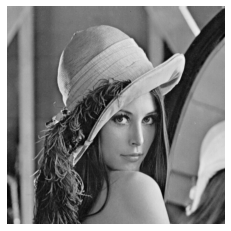

In [ ]:
import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import fftpack
import matplotlib.image as mpimg
import math
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
import plotly.express as px



horizontal_filter = np.array([-1, 0, 1])
vertical_filter = np.array([[-1],
                            [0],
                            [1]])

image_name = "lena512.pgm"
lenna = cv2.imread(image_name,0)
lenna = lenna.astype(float)
plt.imshow(lenna, cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

#Funções

Cálculo dos gradientes

In [ ]:
def gradient(image, filter):

  #padding na imagem 
  new_img = np.zeros((image.shape[0]+2, image.shape[1]+2))
  new_img[1:image.shape[0]+1, 1:image.shape[1]+1] = image
  filtered = np.zeros((new_img.shape))

  for row in np.arange(1, new_img.shape[0]-1):
    for col in np.arange(1, new_img.shape[1]-1):

      curr_region = new_img[row-1:row+2, col-1:col+2]

      #aplicando o filtro
      curr_result = curr_region * filter
      soma = np.sum(curr_result)
      filtered[row, col] = soma

  #Removendo o padding
  filtered_image = filtered[1:filtered.shape[0]-1, 1:filtered.shape[1]-1]

  return filtered_image


h_grad = gradient(lenna, horizontal_filter)
v_grad = gradient(lenna, vertical_filter)


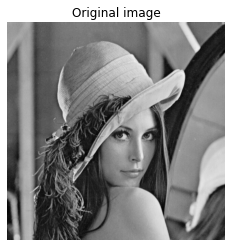

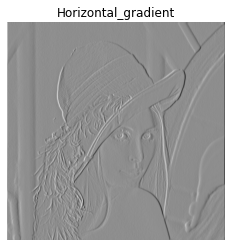

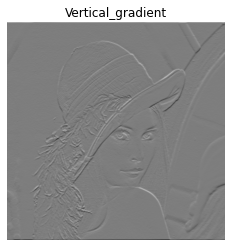

In [ ]:
plt.imshow(lenna, cmap = 'gray')
plt.title('Original image')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

plt.imshow(h_grad, cmap='gray')
plt.title('Horizontal_gradient')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

plt.imshow(v_grad, cmap='gray')
plt.title('Vertical_gradient')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

Cálculo da magnitude e da inclinação

In [ ]:
def magnitude_and_orientation(h_grad, v_grad):
    
    magnitude = np.sqrt(h_grad**2 + v_grad**2)

    orientation = np.arctan(v_grad/(h_grad+0.00000001))
    orientation = np.rad2deg(orientation)
    orientation = orientation % 180

    return magnitude, orientation

magnitude, orientation = magnitude_and_orientation(h_grad, v_grad)

print(magnitude)
print(orientation)




[[458.20519421 486.         485.00412369 ... 497.03118614 460.72225907
  419.74873436]
 [486.           0.           3.         ...  48.         126.
  465.        ]
 [486.           0.           3.         ...  48.         126.
  465.        ]
 ...
 [133.06013678  22.02271555  15.5241747  ...   9.48683298  22.47220505
  303.59512513]
 [131.01526629  29.83286778  41.40048309 ...  11.18033989  15.13274595
  310.36269106]
 [124.45079349 144.68241082 152.77761616 ... 309.16176995 317.1009303
  299.11369076]]
[[ 45.          90.          90.23626992 ...  93.69138599 100.50506387
  137.60694496]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [178.27733793   2.6025622   14.93141717 ...  71.56505112 110.85445802
  176.41189333]
 [  0.87467677  13.57043438  37.14668669 ...  26.56505115  82.40535659
  177.2297842 ]
 [135.          98.74616227 100.94218541 ...  91.85358542  91.445

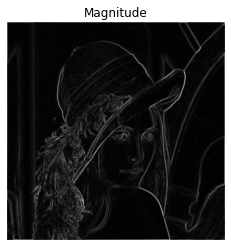

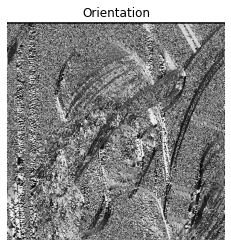

In [ ]:
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitude')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

plt.imshow(orientation, cmap='gray')
plt.title('Orientation')
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

Histograma da célula

In [ ]:
def cell_histogram(magnitude, orientation, bins):
    """
    magnitude = matriz NxN com os valores de magnitude de cada posição(N = lado da celula)
    orientation = matriz NxN com os valores de orientação de cada posição
    bins = array com os valores de cada bin

    retorno: array que representa um histograma da celula

    """
    

    HOG_cell_hist = np.zeros(shape=(bins.size))
    cell_size = orientation.shape[0]
   

    for row_idx in range(cell_size):
        for col_idx in range(cell_size):

            curr_direction = orientation[row_idx, col_idx]
            curr_magnitude = magnitude[row_idx, col_idx]

            #definindo o bin ao qual queremos adicionar
            
            diff = (curr_direction - bins)

            #idx das posições para adicionar a magnitude
            first_bin_idx = np.where(diff >= 0, diff, np.inf).argmin()

            temp = bins[[(first_bin_idx) % (bins.size), (first_bin_idx+1)% (bins.size)]]
            diff2 = np.abs(curr_direction - temp)
            res = np.where(diff2 == np.min(diff2))[0][0]
            
            if res == 0 and first_bin_idx != 0:
                second_bin_idx = first_bin_idx-1
            else:
                second_bin_idx = first_bin_idx+1
        
            first_bin_value = bins[first_bin_idx]
            second_bin_value = bins[second_bin_idx]

            #adicionando as magnitudes no histograma
            HOG_cell_hist[first_bin_idx] = HOG_cell_hist[first_bin_idx] + (np.abs(curr_direction - first_bin_value)/(180.0/bins.size)) * curr_magnitude
            HOG_cell_hist[second_bin_idx] = HOG_cell_hist[second_bin_idx] + (np.abs(curr_direction - second_bin_value)/(180.0/bins.size)) * curr_magnitude

    return HOG_cell_hist



Histograma do bloco

In [ ]:
def block_histogram(image, w, h, s, bins):
    
    block_hist = np.array([])

    for celly in range(0, h, s):
        for cellx in range(0, w, s):
          
          #calculando os gradientes da celula
          cell_image = image[celly : celly+s, cellx : cellx+s]

          h_grad = gradient(cell_image, horizontal_filter)
          v_grad = gradient(cell_image, vertical_filter)

          magnitude, orientation = magnitude_and_orientation(h_grad, v_grad)

          #histograma da celula
          cell_hist = cell_histogram(magnitude, orientation, bins)

          #concatenando
          block_hist = np.append(block_hist,cell_hist)

          #normalizando com a norma L2-Hys
          eps = 1e-7
          normalized_block = np.clip(block_hist / np.sqrt((block_hist**2).sum(axis=-1) + eps), 0, 0.2)
          normalized_block /= np.sqrt((normalized_block**2).sum(axis=-1) + eps)


    return normalized_block

HOG

In [ ]:
def HOGImage(image, w, h, s):
  """ 

  w = largura do bloco
  h = altura do bloco
  s = lado da celula


  """

  HOG_hist = np.array([])

  #9 bins
  bins = np.array([0,20,40,60,80,100,120,140,160])

  horizontal_filter = np.array([-1, 0, 1])
  vertical_filter = np.array([[-1],
                            [0],
                            [1]])


  #bloco
  for blocky in range(0,image.shape[0], h):
    for blockx in range(0,image.shape[1], w):
      
      block = image[blocky:blocky+h, blockx:blockx+w]

      block_hist = block_histogram(block, w, h, s, bins)

      HOG_hist = np.append(HOG_hist, block_hist)
  

  return HOG_hist


In [ ]:
features = HOGImage(lenna, 16,16,8)

In [ ]:
len(features)

36864

#Extraindo o dataset

***Como o programa foi desenvolvido no google colab carregamos o dataset do drive, favor fazer as devidas adaptações para o seu diretório e ambiente.***

In [ ]:
#Importando arquivos do Drive
#->Adaptar para seu proprio diretório ou criar um diretório no Google Drive com mesmos nomes

from google.colab import drive
drive.mount('/content/drive')

#diretório
PWD = 'drive/MyDrive/fashion_mnist_sample/'
# exemplo: PWD = './data/fashion_mnist_sample/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_WIDTH=32
IMG_HEIGHT=32


def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)
            image= cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image= np.array(image)
            image = image.astype('float32')
            image /= 255 
            
            img_data_array.append(image)
            class_name.append(dir1)
            
    return img_data_array, class_name

# extract the image array and class name
img_data, class_name = create_dataset(PWD)

In [ ]:
np.unique(class_name)

array(['Ankle Boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal',
       'Shirt', 'Sneaker', 'T-shirt', 'Trouser'], dtype='<U10')

In [ ]:
dataset_w_hog = [HOGImage(img, 16, 16, 8) for img in img_data]

In [ ]:
def test_and_plot_descriptor(descriptor):

  data_test = pd.DataFrame(descriptor)
  data_test = data_test.fillna(0)

  df1 = pd.DataFrame(class_name, columns = ['class'])
  data_test = pd.concat([data_test, df1], axis = 1)


  tsne = TSNE(n_components=2, random_state=0)
  projections = tsne.fit_transform(data_test.loc[:, data_test.columns != 'class'])
  options = ['Trouser', 'Sandal', 'Pullover']

  df2 = pd.DataFrame(projections)
  df2 = pd.concat([df2, df1], axis = 1)

  df3 = df2[df2['class'].isin(options)]
  fig = px.scatter(df3, x=0, y=1, color="class")
  fig.show()
  fig = px.scatter(df2, x=0, y=1, color="class")
  fig.show()

In [ ]:
test_and_plot_descriptor(dataset_w_hog)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



# Análise dos resultados obtidos com o método HOG iplementado por nós

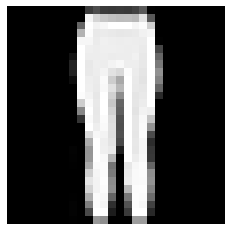

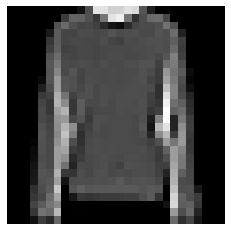

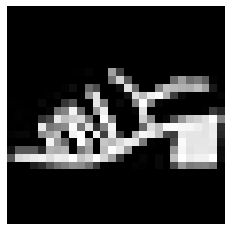

In [ ]:
aux_list = ['Trouser', 'Pullover', 'Sandal']

for i in range(3):
  img_path = 'drive/MyDrive/fashion_mnist_sample/{classe}/000.png'.format(classe = aux_list[i])
  img = cv2.imread(img_path,0)
  img = img.astype(float)
  plt.imshow(img, cmap = 'gray')
  plt.xticks([]), plt.yticks([])
  plt.axis('off')
  plt.show()

##Ánalise dos resultados nas classes 'Trouser', 'Pullover' e 'Sandal'



> Observando o gráfico gerado, vê-se uma separação muito boa das classes, com exceção de três outliers, 1% do dataset. São classes bastante diferentes (como pode-se ver nas imagens acima): calças, sandálias e pullovers. Portanto, como o HOG  se baseia na ideia de que a forma e a aparencia de um objeto podem ser descritas muitas vezes pela intensidade dos gradientes ou a direção das bordas, sem um conhecimento previo da posicão de tais bordas, com um dataset comportado como o utilizado, era de se esperar que este algoritmo fosse eficiente no dissernimento de classes tão distintas.





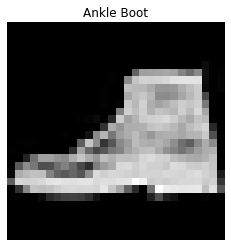

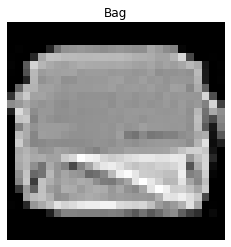

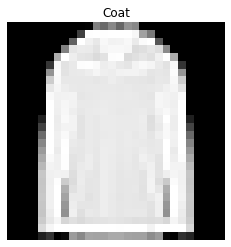

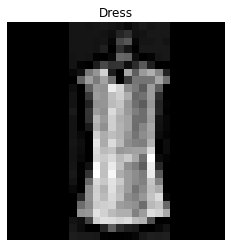

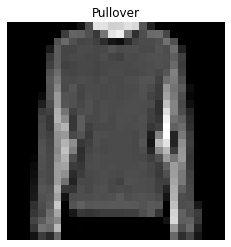

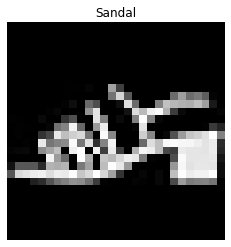

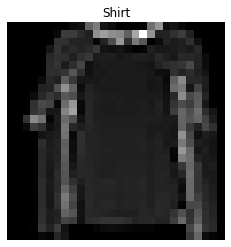

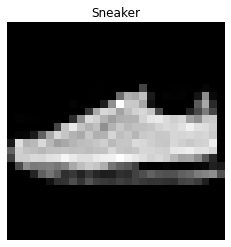

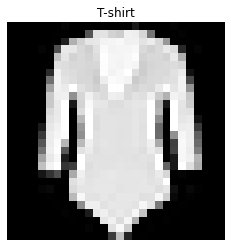

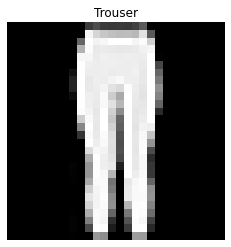

In [ ]:
aux_list = np.unique(class_name)

for i in range(len(aux_list)):
  img_path = 'drive/MyDrive/fashion_mnist_sample/{classe}/000.png'.format(classe = aux_list[i])
  img = cv2.imread(img_path,0)
  img = img.astype(float)
  plt.imshow(img, cmap = 'gray')
  plt.title(aux_list[i])
  plt.xticks([]), plt.yticks([])
  plt.axis('off')
  plt.show()

##Ánalise dos resultados em todas as classes


> Analisando o segundo o gráfico e amostras de cada uma das classes, vê-se que o método HOG cumpre o esperado, tendo em vista as características que ele capta. Observa-se como classes como as classes de calçados ficam próximas e misturadas, da mesma forma que camisas, pullovers, casacos; vestidos e camisetas também se misturam um pouco com estas classes, mas estão levemente separadas. Calças e bolsas foram bem discernidas, visto que possuem formatos bem diferentes.







## Comparando com a utilização do HOG do Skimage

In [ ]:
from skimage.feature import hog

Extraindo o HOG

In [ ]:
hog_features = []
for dir1 in os.listdir(PWD):
        for file in os.listdir(os.path.join(PWD, dir1)):
            image_path= os.path.join(PWD, dir1,  file)
            image = cv2.imread( image_path, 0)
            features = hog(image, orientations=9, pixels_per_cell=(8,8),cells_per_block=(2,2))

            hog_features.append(features)
        

In [ ]:
test_and_plot_descriptor(hog_features)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



Observa-se que o HOG da bibilioteca Skimage apresentou as mesmas dificuldades da implementação feita neste notebook. Logo, esse método tem problemas em diferenciar objetos de classes que têm bordas parecidas, porém que têm texturas diferentes.

#Local Binary Pattern

O LBP é um método que visa caracterizar a texturas de objetos na imagem. A partir disso, é possível extrair features para representar cada imagem.
  

In [ ]:
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

def hist(lbp):
    n_bins = int(lbp.max() + 1)
    return np.histogram(lbp.ravel(),density=True, bins=n_bins, range=(0, n_bins))

radius = 3
n_points = 8 * radius
METHOD = 'uniform'

In [ ]:
lbp_hists = []
for dir1 in os.listdir(PWD):
        for file in os.listdir(os.path.join(PWD, dir1)):
            image_path= os.path.join(PWD, dir1,  file)
            image = cv2.imread( image_path, 0)
            lbp = local_binary_pattern(image,n_points, radius, METHOD )
            histogram = hist(lbp)[0]

            lbp_hists.append(histogram)     

In [ ]:
test_and_plot_descriptor(lbp_hists)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



A partir destas plotagens é possível observar que o LBP não funciona muito bem para as imagens deste dataset. Isso se deve à alta similaridade das texturas das imagens e da simplicidade , devido à baixa dimensionalidade das imagens. Como cada imagem tem apenas 28x28 pixels, verifica-se que são imagens pouco detalhadas, o que prejudica a optimalidade desse algoritmo.

# Aqui testamos métodos mais simples para a extração de features, seguem os plots e as análises realizadas:

---



## Canny Edge Detection

> Primeiramente, utilizamos o método Canny Edge Detection, disponível na biblioteca OpenCV. Ele extrai as bordas dos objetos utilizando de redução de ruído, seguido do cálculo da intensidade e direção dos gradientes da imagem e por fim, da escolha das partes da imagem que realmente consistem de bordas e gera-se a imagem final.
Nós transformamos essa imagem de saída em um vetor de 784 posições (28 x 28), e fornecemos ao t-SNE todos os vetores gerados a partir do dataset. 

In [ ]:
canny = []
for dir1 in os.listdir(PWD):
        for file in os.listdir(os.path.join(PWD, dir1)):
       
            image_path= os.path.join(PWD, dir1,  file)
            image = cv2.imread( image_path, 0)
            edges = cv2.Canny(image=image, threshold1=100, threshold2=2)
            canny.append(edges.reshape(784)) 

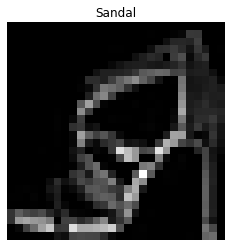

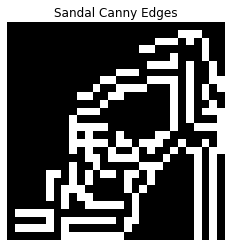

In [ ]:
plt.imshow(image, cmap = 'gray')
plt.title("Sandal")
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()
plt.imshow(edges, cmap = 'gray')
plt.title("Sandal Canny Edges")
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
test_and_plot_descriptor(canny)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



> Observa-se, no primeiro plot, que o método separa relativamente bem as classes, de maneira pior que o HOG, visto que os pontos estão mais esparsos e as classes não estão tão distantes, porém as separa. No segundo plot, vê-se um cenário bem mais caótico e menos segregado que o plot gerado com o método HOG, tanto o implemnetado por nós quanto o da biblioteca skimage. Embora haja uma leve separação entre calçados e demais classes, o resultado obtido parece ser bem ineficaz para a separação das classes, a classe bag ficou completamente espalhada, e as demais, mesmo que com concentrações como a classe Trouser e Dress, ficaram bastante misturadas.

> Como o dataset consiste de imagens pequenas e pouco detalhadas, um método que utilize somente do formato das bordas dos objetos em questão, no caso roupas, será pouco eficaz, como observado. Muitas classes como as de vestimentas da parte do torso e até mesmo a calça e a bolsa, possuem um formato quadrado, que varia pouco, o que impede um bom discernimento e distanciamento das classes pelo t-SNE. Os descritores gerados para essas classes são bem semelhantes.

## Projeções em cada eixo e em ambos


### Projeção no eixo horizontal

Como descritores utilizamos um vetor onde cada índice é a soma cumulativa da coluna correspondente da imagem original, não foi feita nenhuma normalização para captar também as diferenças da parte interna de cada objeto.

In [ ]:
colsums = []
for dir1 in os.listdir(PWD):
        for file in os.listdir(os.path.join(PWD, dir1)):
       
            image_path= os.path.join(PWD, dir1,  file)
            image = cv2.imread( image_path, 0)
            
            colsums.append(image.sum(axis=0)) 

In [ ]:
test_and_plot_descriptor(colsums)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



> Os resultados obtidos foram relativamente satisfatórios. Houve uma boa separação das classes Trouser, Sandal e Pullover. No plot com todas as classes, observa-se como os calçados e a classe bag ficam bem separados e agrupados, o que demonstra que este pode ser um descritor razoavelmente bom, a depender da tarefa e da precisão necessária. Assim como os outros métodos analisados, as classes das roupas da parte de cima do corpo e a classe Trouser, não são bem separadas por esse tipo de descritor, observa-se um agrupamento da classe Trouser e Dress, mas as demais estão misturadas.


### Projeção no eixo vertical
Como descritores utilizamos um vetor onde cada índice é a soma cumulativa da linha correspondente da imagem original, não foi feita nenhuma normalização para captar também as diferenças da parte interna de cada objeto.




In [ ]:
rowsums = []
for dir1 in os.listdir(PWD):
        for file in os.listdir(os.path.join(PWD, dir1)):
       
            image_path= os.path.join(PWD, dir1,  file)
            image = cv2.imread( image_path, 0)
            
            rowsums.append(image.sum(axis=1))

In [ ]:
test_and_plot_descriptor(rowsums)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



> Utilizando a projeção vertical como descritor não gera um resultado tão bom quanto a quando utilizando a projeção horizontal, encontram-se resultados semelhantes mas um pouco piores. Os calçados continuam agrupados, porém menos separados, assim como a classe bag. A classe Trouser está relativamente agrupada, mas mais esparsa. E as demais aparentam estar mais esparsas e misturadas também.

### Projeção em ambos os eixos

Por fim, concatenamos ambos os conjuntos de descritores, ao longo do eixo 1, para gerar um grande descritor com as duas projeções

In [ ]:
colsums_concat_rowsums = np.concatenate((np.array(colsums), np.array(rowsums)), axis=1)

In [ ]:
test_and_plot_descriptor(colsums_concat_rowsums)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



> Ao utilizar como descritor a concatenação dos dois descritores, o resultado parece ser satisfatório o bastante para uma tarefa de classificação, as classes, embora espalhadas em alguns aspectos, possuem certa segregação. Os calçados estão bem separados até mesmo entre si, a classe Bag e está relativamente bem concentrada em uma região, assim como a classe Trouser. As demais, assim como nos outros métodos estão relativamente espalhadas.

### Comparando com o HOG
> Os melhores resultados dentre as projeções foram as projeções no eixo horizontal e em ambos os eixos. Contudo, o método do HOG ainda performa muito melhor nessa tarefa, gerando clusters bem mais concentrados das classes as separando de forma mais eficiente.
As projeções são descritores simples e mais rápidos, porém não capturam as peculiaridades das classes, o que justifica a separação menos intensa entre as classes, como observado nos gráficos gerados.
